# Сеть Кохонена

## Теория

### Определение

Нейронная сеть Кохонена -- класс нейронных сетей, основным элементом которых является слой Кохонена, работающий по принципу "Победитель получает всё", т.е. на любой входной сигнал активируется только один нейрон. Нейрон имеет вектор весов с длинной равмым размерности пространства, фактически нейрон является точкой в пространтсве. Нейрон победитель определяется путём выбора ближайшего нейрона к образцу, соответсвенно образцу назначается кластер нейрона. В качестве меры близости зачастую выбирается евклидово растояние



### Обучение сети

#### Алгоритм обучения 

* Инициализируются веса
* В цикле по количеству эпох
* * Для каждого образца
* * * Выбор нейрона победителя ( ближайшего )
* * * Обновить его веса

Нейрон победитель выбирается ближайший к образцу, однако с целью уменьшения вероятности переобучения используется механизм регуляции, он представляет собой ограничение на максимальное количество побед нейроном до 1

Ещё одно средство контроля процесса обучения это ввода коэффициента скорости обучения, или меры инертности. В базовой реализации веса нейрона принимаются равными вектору координат обучающего образца, однако это может приводить к слишком большим изменениям весов нейронов, и как следствие снижению качества обучения.

#### Проверка качества результата 

Для оценки качества кластеризации использовался коэффициент силуэта

Коэффициент силуэта является примером такой оценки, где более высокий показатель коэффициента силуэта относится к модели с лучше определенными кластерами. Коэффициент силуэта определяется для каждого образца и состоит из отношения разницы среднего растояния от образца до других в его кластере к среднему расстоянию до образцов в ближайшем кластере к максимальному из данных величин

Оценка ограничена между -1 для неправильной кластеризации и +1 для очень плотной кластеризации. Оценки около нуля указывают на перекрывающиеся кластеры.

Оценка выше, когда кластеры плотные и хорошо разделены, что соответствует стандартной концепции кластера.

## Реализация сети

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def euclid_dist(a, b):
    return np.linalg.norm(a - b)


class Kohen:
    def __init__(self, c_num, dist_metric, speed=0.5, random_seed=None):
        np.random.seed(random_seed)  # для повторяемости

        self.c_num = c_num  # количество нейронов, максимального количества кластеров
        self.dist = dist_metric  # метрика расстояния
        self.speed = speed  # скорость обучения

        self.neurons = None  # 
        self.labels = None
        # для лучшего обучения данные масштабируются, данный объект позволит сохранить данные об обучащией выборке
        # для преобразования образцов во время работы модели на образцах, не включённых в обучающую выборку
        self.scaler = MinMaxScaler()

    def fit(self, data, epoch: int):
        x = self.scaler.fit_transform(data)
        self.neurons = np.random.random((self.c_num, x.shape[1]))  # инициализация весов
        self.labels = list(range(self.c_num))
        idx_sequence = [i for i in range(len(x))]  # для изменения порядка образцов на каждой эпохе
        for e in range(epoch):
            np.random.shuffle(idx_sequence)
            for idx in idx_sequence:
                win_idx = 0
                last_win = 0
                for i in range(len(self.neurons)):
                    if self.dist(x[idx], self.neurons[win_idx]) < self.dist(x[idx], self.neurons[i]):
                        if i == last_win:  # чтобы один победитель не был два раза/ регуляция
                            continue
                        else:
                            win_idx = i
                last_win = win_idx
                self.clusters[win_idx] =  (1 - self.speed) * self.clusters[win_idx] + self.speed * (x[idx] - self.clusters[win_idx])  # обновление весов


    def pred(self, x):
        scal_x = self.scaler.transform(x.reshape(1, -1))
        
        return max(self.labels, key=lambda c: self.dist(scal_x, self.neurons[c]))

## Функция для обучения сетей и выбора лучшей 

In [19]:
from sklearn import metrics

def train(x, neuro=(2,10), speed=(0.3, 0.4, 0.5, 0.6, 0.7, 0.8), epoch=(2,12), count=7):
    """В данной функции происходит обучение множества моделей с перебором всех возможных комбинаций параметров
    
    также для каждого набора параметров происходит обучение нескольких моделей, так как один из гиперпараметров
    это начальные значения весовых коэффициентов, которые при создании модели задаются случайным образом
    метрика качества -- оценка силуэта."""
    import time
    min_neuro = neuro[0]
    max_neuro = neuro[1]
    min_epoch = epoch[0]
    max_epoch = epoch[1]
    res = {}
    t = time.localtime()
    print(f'start time is: {t.tm_hour}:{t.tm_min}:{t.tm_sec}')
    for neuron_count in range(min_neuro, max_neuro+1):
        k_arr = []
        for s in speed:
            for e in range(min_epoch, max_epoch+1):
                for _ in range(count):
                    k = Kohen(neuron_count, euclid_dist, random_seed=None, speed=s)
                    k.fit(data=x, epoch=e)
                    res_labels = list(map(k.pred, x))
                    try:  # модель может переобучиться и мы получим один кластер, что вызовет ошибку вычисления силуэта
                        score = metrics.silhouette_score(x, res_labels)
                    except ValueError:
                        score = 0
                    k_arr.append([score, (e, s), k])
        best_k = max(k_arr, key=lambda x: x[0])
        # выбор уникальных кластеров, т.к количество нейронов не означет, что кластеров будет столько
        k = best_k[2]
        nunique = len(set(map(k.pred, x)))
        best_k.append(nunique)
        res[neuron_count] = best_k
        t = time.localtime()
        print(f'нейронов: {neuron_count} || метрика: {best_k[0]} || (эпоха, скорость): {best_k[1]} || уникальных кластеров: {best_k[3]} || ({t.tm_hour}:{t.tm_min}:{t.tm_sec})')
    return res

# Работа нейросети

In [3]:
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Загрязнение в Индии
https://www.kaggle.com/adityadeshpande23/pollution-india-2010

### Содержательная постановка задачи
Правительство Индии хочет улучшить экологию в стране путём продения серии проектов в данной сфере. Для более эффективного внедрения проектов предполагается разделение городов на группы со схожим экологическим положением, это позволит использовать одни и теже наработки в пределах группы городов с одинаковой эффективностью, что позволит снизить расходы на разработку проектов за счёт необходимости в меньшем количестве исследований.
Деление на группы будет происходить на основании состава воздуха в городах.

Даны результаты измерения концентрации загрязняющих веществ в различных городах, представленных следующим перечнем:

* NO2 - Оксид азота (мкг/м3).
* PM10 - частицы того или иного твёрдого вещества диаметром от 10 микрометра (мкм) и меньше (мкг/м3).
* SO2 - Оксид серы (мкг/м3).

Требуется провести разделение городов на группы с целью повышения оптимальности принятия управленческих решений в сфере экологии

In [4]:
clust_df = pd.read_csv("pollution_india_2010 (1).csv", na_values=["Null"])

In [28]:
clust_df.head()

,City,NO2,PM10,SO2,State
0,Chitoor,9.0,39.0,4.0,Andhra Pradesh
1,Guntur,11.0,81.0,2.0,Andhra Pradesh
2,Hydrabad,24.0,79.0,5.0,Andhra Pradesh
3,Kothagudem,11.0,62.0,2.0,Andhra Pradesh
4,Kurnool,9.0,85.0,4.0,Andhra Pradesh


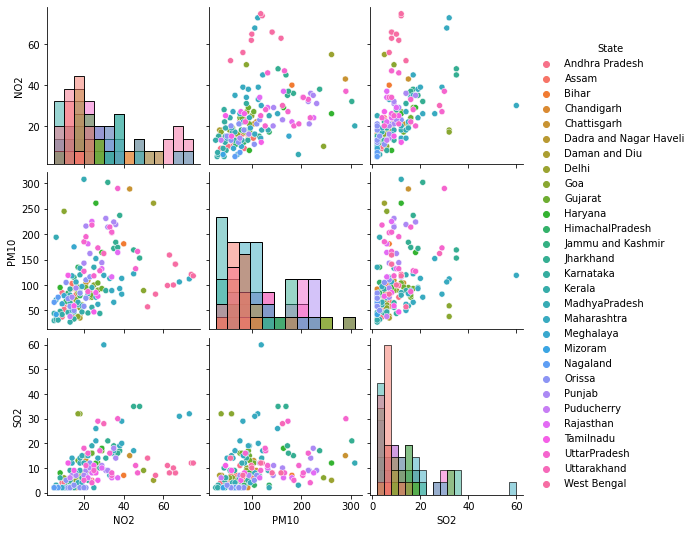

In [38]:
sns.pairplot(data=clust_df, hue='State', diag_kind ='hist')

### Изунение исходных данных

#### Устранение пропусков 

In [39]:
clust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    181 non-null    object 
 1   NO2     177 non-null    float64
 2   PM10    180 non-null    float64
 3   SO2     176 non-null    float64
 4   State   181 non-null    object 
dtypes: float64(3), object(2)
memory usage: 7.2+ KB


--- 

Для устранения пропусков было решено взять средние значения по административной единице

In [5]:
clear_df = clust_df.groupby('State').transform(lambda x: x.fillna(x.mean()))

In [41]:
clear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     181 non-null    float64
 1   PM10    181 non-null    float64
 2   SO2     181 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


---

Пропуски устранены, в датасете остались только числовые поля, необходимые для обучения

#### Выведем матрицу объект объект

In [16]:
from sklearn.metrics.pairwise import euclidean_distances
o_o_matrix = euclidean_distances(x,x)
pd.DataFrame(o_o_matrix)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.000000,42.095130,42.731721,23.173260,46.000000,48.093659,26.248809,40.174619,29.154759,2.000000,...,175.914752,116.914499,104.942842,116.914499,47.675990,103.252119,80.361682,131.651054,83.024093,63.773035
1,42.095130,0.000000,13.490738,19.000000,4.898979,13.000000,16.031220,15.811388,13.190906,44.090815,...,134.899963,81.614950,75.292762,81.614950,49.000000,74.598928,54.827001,93.936149,57.801384,45.287967
2,42.731721,13.490738,0.000000,21.610183,16.186414,6.082763,18.681542,6.782330,16.309506,44.609416,...,135.107365,74.946648,65.673435,74.946648,36.728735,64.583280,43.358967,89.050547,46.335731,32.202484
3,23.173260,19.000000,21.610183,0.000000,23.173260,26.115130,3.162278,20.518285,6.403124,25.159491,...,153.417730,96.446877,86.890736,96.446877,43.011626,85.627099,63.647467,110.222502,66.513157,49.497475
4,46.000000,4.898979,16.186414,23.173260,0.000000,14.035669,20.322401,18.055470,17.262677,48.000000,...,130.942736,80.006250,74.732858,80.006250,52.278102,74.222638,55.263008,91.695147,58.283788,47.191101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,103.252119,74.598928,64.583280,85.627099,74.222638,61.983869,82.933708,66.850580,80.826976,104.790267,...,105.437185,25.019992,3.162278,25.019992,65.222695,0.000000,23.043437,42.906876,20.688161,41.012193
177,80.361682,54.827001,43.358967,63.647467,55.263008,41.868843,61.131007,45.276926,59.245253,81.865744,...,118.667603,42.296572,25.079872,42.296572,43.278170,23.043437,0.000000,60.083276,3.316625,18.466185
178,131.651054,93.936149,89.050547,110.222502,91.695147,84.172442,107.112091,92.184597,104.393486,133.476590,...,65.559134,18.248288,39.761791,18.248288,102.766726,42.906876,60.083276,0.000000,59.067758,77.323994
179,83.024093,57.801384,46.335731,66.513157,58.283788,44.877611,64.015623,48.383882,62.201286,84.504438,...,118.713942,41.060930,22.934690,41.060930,45.099889,20.688161,3.316625,59.067758,0.000000,20.346990


#### Матрица объект признак

In [18]:
pd.DataFrame(data=x, index=["Объект_"+str(i) for i in range(x.shape[0])], columns=["Признак_"+str(i) for i in range(x.shape[1])])

,Признак_0,Признак_1,Признак_2
Объект_0,9.0,39.0,4.0
Объект_1,11.0,81.0,2.0
Объект_2,24.0,79.0,5.0
Объект_3,11.0,62.0,2.0
Объект_4,9.0,85.0,4.0
...,...,...,...
Объект_176,75.0,118.0,12.0
Объект_177,62.0,99.0,11.0
Объект_178,63.0,159.0,8.0
Объект_179,65.0,100.0,10.0


### Обучение сети 

In [9]:
x = clear_df.values  # получение из датасета непосредственно числовых значений без метаинформации

In [43]:
res = train(x)

start time is: 16:59:5
нейронов: 2 || метрика: 0.6256909727836447 || (эпоха, скорость): (10, 0.3) || уникальных кластеров: 2 || (16:59:45)
нейронов: 3 || метрика: 0.60948040457977 || (эпоха, скорость): (11, 0.7) || уникальных кластеров: 2 || (17:0:29)
нейронов: 4 || метрика: 0.6049957519737308 || (эпоха, скорость): (8, 0.7) || уникальных кластеров: 2 || (17:1:26)
нейронов: 5 || метрика: 0.5480010934376055 || (эпоха, скорость): (5, 0.8) || уникальных кластеров: 2 || (17:2:30)
нейронов: 6 || метрика: 0.6054042888509885 || (эпоха, скорость): (4, 0.8) || уникальных кластеров: 2 || (17:3:47)
нейронов: 7 || метрика: 0.49975611056899355 || (эпоха, скорость): (11, 0.6) || уникальных кластеров: 3 || (17:5:6)
нейронов: 8 || метрика: 0.4862911489473782 || (эпоха, скорость): (12, 0.8) || уникальных кластеров: 3 || (17:6:30)
нейронов: 9 || метрика: 0.6051326424103148 || (эпоха, скорость): (8, 0.6) || уникальных кластеров: 2 || (17:8:4)
нейронов: 10 || метрика: 0.42001445781231195 || (эпоха, скорост

---

Особенность работы алгоритма в том, что количество нейронов говорит о максимальном возможном количестве выделенных кластеров.Из вывода обучающей функции можно сделать вывод о том, что фактически в данных присутствуют только две группы образцов


In [87]:
# Сохранение результатов обучения в файл
import pickle
with open('res', 'wb') as res_file:
    pickle.dump(res, res_file)

### Изучение результатов работы алгоритма
Для этого возьмём модель с наилуйшим значением метрики и разметим исходные данные

In [ ]:
import pickle
with open('res', 'rb') as res_file:
    pickle.load(res, res_file)

In [48]:
best_k = res[0][-2]

In [52]:
clusted_df = clust_df.assign(cluster=list(map(best_k.pred, x)))

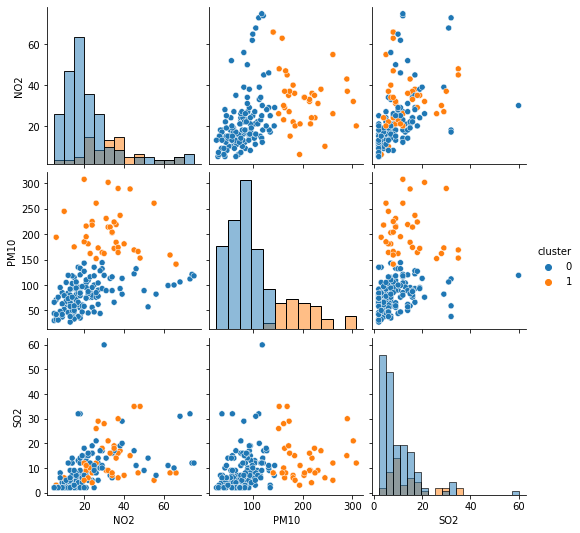

In [53]:
sns.pairplot(data=clusted_df, hue='cluster', diag_kind ='hist')

На графиках некоторых зависимостей можно наблюдай явное разделение образцов, без пересечений

Изучим данные в каждой отдельной группе

In [60]:
clust_0_df = clusted_df[clusted_df.cluster == 0]
clust_1_df = clusted_df[clusted_df.cluster == 1]

len(clust_0_df)=139  || len(clust_1_df)=42


In [59]:
clust_0_df.describe()

,NO2,PM10,SO2,cluster
count,137.000000,139.000000,137.000000,139.0
mean,21.496350,80.172662,8.948905,0.0
std,13.970096,28.333400,7.920860,0.0
min,5.000000,27.000000,2.000000,0.0
25%,13.000000,58.500000,4.000000,0.0
50%,18.000000,79.000000,7.000000,0.0
75%,25.000000,99.500000,12.000000,0.0
max,75.000000,144.000000,60.000000,0.0


In [58]:
clust_1_df.describe()

,NO2,PM10,SO2,cluster
count,40.000000,41.000000,39.000000,42.0
mean,33.075000,202.829268,13.564103,1.0
std,13.708293,43.905525,8.665706,0.0
min,6.000000,141.000000,3.000000,1.0
25%,23.750000,169.000000,8.000000,1.0
50%,32.500000,195.000000,10.000000,1.0
75%,37.250000,224.000000,17.500000,1.0
max,66.000000,308.000000,35.000000,1.0


рассмотрим распределения показаний вредных веществ

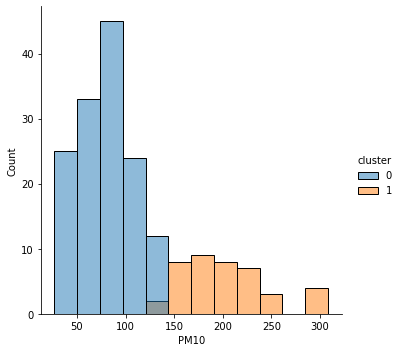

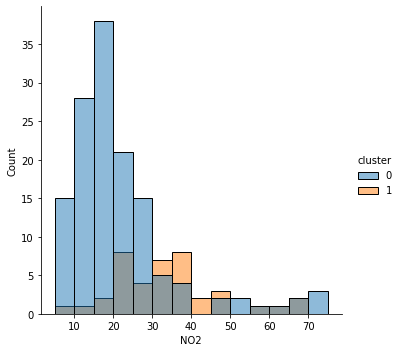

In [88]:
sns.displot(data=clusted_df, x='PM10', hue='cluster')
sns.displot(data=clusted_df, x='NO2', hue='cluster')

Видно, что один кластер характеризуется высокими значениями PM10, а другой наоборот -- низкими. В некоторой степени можно говорить о том, что и по уровню оксида азота (NO2) данные также делятся на два кластера, при этом наблюдается некоторое пересечение кластеров, примерно 25% значений, в некоторой степени это можно объяснить корреляцией значений друг-с-другом, причиной которой можно предположить выделение объектами, загрязняющих воздух, всех трёх веществ. 

In [85]:
clusted_df.corr()

,NO2,PM10,SO2,cluster
NO2,1.000000,0.394014,0.442424,0.330404
PM10,0.394014,1.000000,0.293243,0.846832
SO2,0.442424,0.293243,1.000000,0.231815
cluster,0.330404,0.846832,0.231815,1.000000


Заметна корреляция между признаками

### Вывод
* Совокупность населённых пунктов Индии, на основании концентрации вредных веществ в воздухе, можно разбить на два кластера, анализ данных с учётом проведённой кластеризации позволил выделить следующие отличия между группами. 
* Одна группа характеризуется высокими значениями концентрации вредных веществ, при этом главную роль в разделении играют PM10 и NO2, что можно объяснить, в том числе и корреляцией их между собой.
* Городов в группе с высокой концентрацией вредных веществ 30% 42/139.
* Разделение на группы позволит министерству экологии Индии вести раздельную политику для данных групп, и строить баланс распределения ресурсов для концентрации на определённой совокуности городов, объединение в группы позволит создавать комитеты из представителей городов, входящих данные группы, а также применять одни и теже проекты в пределах одной группы городов, экономя ресурсы на их разработку
